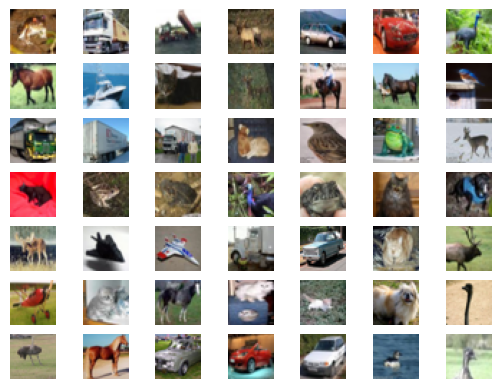

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
>Epoch 1, Batch 1/7, D1=0.688, D2=0.691, G=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
>Epoch 1, Batch 2/7, D1=0.690, D2=0.691, G=0.693
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>Epoch 1, Batch 3/7, D1=0.690, D2=0.691, G=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>Epoch 1, Batch 4/7, D1=0.690, D2=0.691, G=0.692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>Epoch 1, Batch 5/7, D1=0.690, D2=0.691, G=0.691
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
>Epoch 1, Batch 6/7, D1=0.691, D2=0.692, G=0.690
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>Epoch 1, Batch 7/7, D1=0.691, D2=0.692, G=0.688
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
>Epoch 2, Batch 1/7, D1=0.692, D2=0.693, G=0.686
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
>Epoch 2, Batch 2/7, D1=0.693, D2=0.695, G=0.683
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>Epoch 2, Batch 3/7, D1=0.694, D2=0.697, G=0.679
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
>Epoch 2, Batch 4/7, D1=0.696, D2=0.699, G=0.674
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
>Epo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


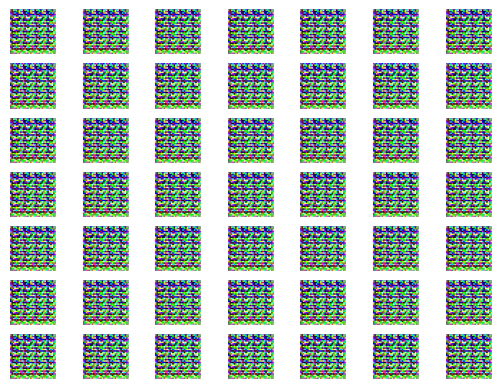

In [ ]:


# ----------------------------------------
# Imports and Dataset Visualization
# ----------------------------------------

import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from keras.datasets.cifar10 import load_data
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, Reshape
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Load CIFAR-10 data and visualize a few samples
(train_images, _), (_, _) = load_data()
for i in range(49):
    plt.subplot(7, 7, 1+i)
    plt.axis('off')
    plt.imshow(train_images[i])
plt.show()

# ----------------------------------------
# Helper Function: Normalize Dataset
# ----------------------------------------
def load_real_images():
    (train_images, _), (_, _) = load_data()
    images = train_images.astype('float32')
    images = (images - 127.5) / 127.5  # Normalize to [-1, 1]
    return images

# ----------------------------------------
# Build the Discriminator Model
# ----------------------------------------
def build_discriminator(input_shape=(32, 32, 3)):
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        LeakyReLU(0.2),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2D(256, (3, 3), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# ----------------------------------------
# Generate Real and Fake Samples
# ----------------------------------------
def get_real_samples(dataset, num_samples):
    indices = np.random.randint(0, dataset.shape[0], num_samples)
    images = dataset[indices]
    labels = np.ones((num_samples, 1))  # Label real as 1
    return images, labels

def get_noise_samples(num_samples):
    noise = np.random.rand(32 * 32 * 3 * num_samples)
    noise = -1 + noise * 2
    noise = noise.reshape((num_samples, 32, 32, 3))
    labels = np.zeros((num_samples, 1))  # Label fake as 0
    return noise, labels

# ----------------------------------------
# Train the Discriminator Alone (Optional Pretraining)
# ----------------------------------------
def train_discriminator_only(discriminator, dataset, epochs=20, batch_size=128):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        real_images, real_labels = get_real_samples(dataset, half_batch)
        fake_images, fake_labels = get_noise_samples(half_batch)

        d_loss_real, acc_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake, acc_fake = discriminator.train_on_batch(fake_images, fake_labels)

        print(f">{epoch+1} Real Acc={acc_real*100:.2f}%, Fake Acc={acc_fake*100:.2f}%")

# ----------------------------------------
# Build the Generator Model
# ----------------------------------------
def build_generator(noise_dim):
    model = Sequential([
        Dense(256 * 4 * 4, input_dim=noise_dim),
        LeakyReLU(0.2),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Conv2D(3, (3, 3), activation='tanh', padding='same')
    ])
    return model

# ----------------------------------------
# GAN Model: Combine Generator and Discriminator
# ----------------------------------------
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# ----------------------------------------
# Generate Latent Points
# ----------------------------------------
def generate_latent_points(noise_dim, num_samples):
    noise = np.random.randn(noise_dim * num_samples).reshape(num_samples, noise_dim)
    return noise

# Generate Fake Samples from Generator

def generate_images_from_generator(generator, noise_dim, num_samples):
    noise = generate_latent_points(noise_dim, num_samples)
    images = generator.predict(noise)
    labels = np.zeros((num_samples, 1))
    return images, labels

# ----------------------------------------
# Performance Summarizer (Save Model and Plots)
# ----------------------------------------
def save_generated_images(images, epoch, n=7):
    images = (images + 1) / 2.0  # Rescale to [0,1]
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
    filename = f"generated_plot_e{epoch+1:03d}.png"
    plt.savefig(filename)
    plt.close()

def evaluate_and_save(epoch, generator, discriminator, dataset, noise_dim, num_samples=150):
    real_images, real_labels = get_real_samples(dataset, num_samples)
    _, acc_real = discriminator.evaluate(real_images, real_labels, verbose=0)
    fake_images, fake_labels = generate_images_from_generator(generator, noise_dim, num_samples)
    _, acc_fake = discriminator.evaluate(fake_images, fake_labels, verbose=0)
    print(f"> Accuracy - Real: {acc_real*100:.2f}%, Fake: {acc_fake*100:.2f}%")
    save_generated_images(fake_images, epoch)
    generator.save(f"generator_model_{epoch+1:03d}.h5")

# ----------------------------------------
# GAN Training Loop
# ----------------------------------------
def train_gan(generator, discriminator, gan_model, dataset, noise_dim, epochs=1, batch_size=128): #change epoch 100 for complete training
    batches_per_epoch = dataset.shape[0] // batch_size
    half_batch = batch_size // 2

    for epoch in range(epochs):
        for batch in range(batches_per_epoch):
            real_images, real_labels = get_real_samples(dataset, half_batch)
            fake_images, fake_labels = generate_images_from_generator(generator, noise_dim, half_batch)

            d_loss_real, _ = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake, _ = discriminator.train_on_batch(fake_images, fake_labels)

            noise_input = generate_latent_points(noise_dim, batch_size)
            gan_labels = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(noise_input, gan_labels)

            print(f">Epoch {epoch+1}, Batch {batch+1}/{batches_per_epoch}, D1={d_loss_real:.3f}, D2={d_loss_fake:.3f}, G={g_loss:.3f}")

        if (epoch + 1) % 10 == 0:
            evaluate_and_save(epoch, generator, discriminator, dataset, noise_dim)


# ----------------------------------------
# Execute Training
# ----------------------------------------
noise_dim = 100
discriminator = build_discriminator()
generator = build_generator(noise_dim)
gan_model = build_gan(generator, discriminator)

cifar10_dataset = load_real_images()
cifar10_dataset = cifar10_dataset[:1000]  # Only 1000 images instead of 50,000
train_gan(generator, discriminator, gan_model, cifar10_dataset, noise_dim, epochs=10, batch_size=128)

# ----------------------------------------
# Inference: Generate Images from Trained Generator
# ----------------------------------------
# from keras.models import load_model
# generator = load_model('generator_model_100.h5')

latent_points = generate_latent_points(noise_dim=100, num_samples=100)
generated_images = generator.predict(latent_points)
generated_images = (generated_images + 1) / 2.0

for i in range(49):
    plt.subplot(7, 7, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i])
plt.show()
